In [16]:
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import datetime
#### import script 
from util import rates_model, instruments, xVA_calc

#### Definizione market data

In [19]:
today = ql.Date.from_date(datetime.datetime.now())
ql.Settings.instance().setEvaluationDate(today)
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
daycount = ql.Actual365Fixed()
yieldTermStructure = ql.FlatForward(today, rate_handle, daycount)
yieldTermStructure.enableExtrapolation()
handleYieldTermStructure = ql.RelinkableYieldTermStructureHandle(yieldTermStructure)
t0_curve = ql.YieldTermStructureHandle(yieldTermStructure)
index = ql.Euribor6M(handleYieldTermStructure)
calendar = ql.TARGET()
daycounter = yieldTermStructure.dayCounter()

#### Booking dello swap e creazione time grid

In [29]:
notional = 1e6
fixedRate = 0.03 # fair rate
settlementDate = calendar.advance(today, ql.Period("3d")) 
maturity = settlementDate + ql.Period("10Y")

swap = instruments.makeSwap(settlementDate, maturity, notional, fixedRate, index) 
swap_fixed_schedule = list(swap.fixedSchedule())
date_grid = [today] + swap_fixed_schedule[1:-1] 
date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

#### Simulazione tasso e exposure

In [23]:
nPath = 1000
mean_rev = 0.03
sigma = 0.0075
r0 = t0_curve.forwardRate(0,1/365, ql.Continuous).rate() # forward istantaneo

In [24]:
# nel loop vengono chiamati gli script che eseguono il 
# calcolo dello short rate con Hull-White la simulazione dell'exposure
m = len(time_grid)
r_t = np.zeros((nPath, m))
r_std = np.zeros((nPath, m))
swapExposure = np.zeros((nPath, m))
flt = np.zeros((nPath, m))
fix = np.zeros((nPath, m))
for i in range(nPath):
    r_t[i], r_std[i]= rates_model.short_rate_path(mean_rev, sigma, time_grid, r0)
for i in range(len(date_grid)):
    swapExposure[:,i],flt[:,i],fix[:,i]=np.vectorize(rates_model.swapPathNPV(swap,
                                                                             date_grid[i],
                                                                             today, 
                                                                             date_grid,
                                                                             mean_rev,
                                                                             sigma,
                                                                             r0))(r_t[:,i])

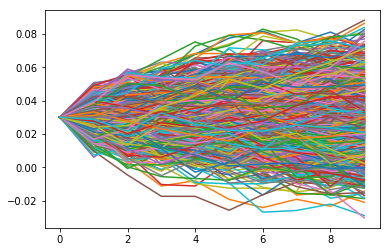

In [25]:
plt.plot(r_t.T);

In [26]:
myhw = ql.HullWhite(t0_curve, mean_rev, sigma)
print("-"*50)
print("Confronto ZCB modello a mano vs QuantLib: ")
print('Bond HW QuantLib: %0.7f' % myhw.discountBond(0,2,r0))
print('Bond HW py: %0.7f' % rates_model.ZCB(0,2, r_t[0,0], r0, mean_rev, sigma))
print('ZeroBond curva t0: %0.7f' % t0_curve.discount(2))

--------------------------------------------------
Confronto ZCB modello a mano vs QuantLib: 
Bond HW QuantLib: 0.9417645
Bond HW py: 0.9417645
ZeroBond curva t0: 0.9417645


#### Swap Exposure 

In [27]:
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)
swap.setPricingEngine(engine)
npv,_,_ = rates_model.swapPathNPV(swap, date_grid[0],today, 
                                  date_grid, mean_rev, sigma, r0)(r_t[0,0])
print("Swap NPV a t0: %.4f" % npv)
print("Quantlib NPV a t0: %.4f" % swap.NPV())
print("Errore : %.8f" % (npv - swap.NPV()))

Swap NPV a t0: 326.5565
Quantlib NPV a t0: 326.5565
Errore : 0.00000016


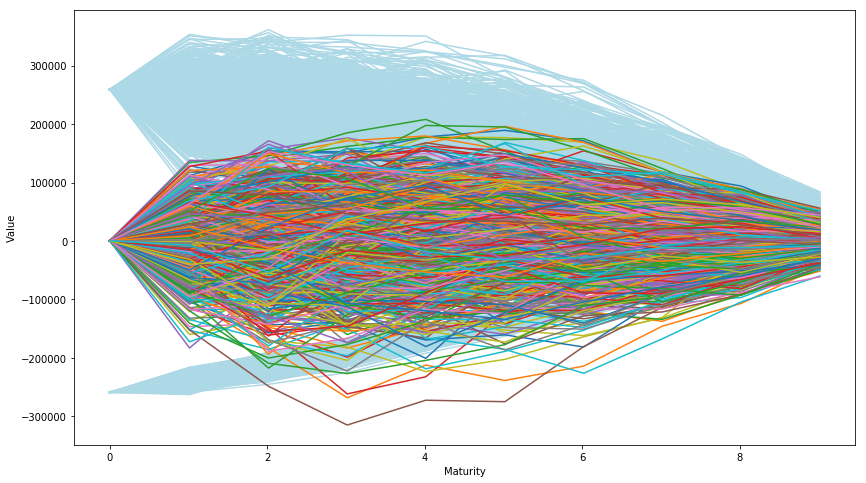

In [28]:
fig = plt.figure(figsize=(14,8))
plt.plot(time_grid, -fix.T, color = "lightblue")
plt.plot(time_grid, flt.T, color = "lightblue")
plt.plot(time_grid, swapExposure.T)
plt.xlabel("Maturity")
plt.ylabel("Value")
plt.show()

#### xVA 

In [30]:
#  curva PD
pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
pdcurve = [0.02 * i for i in range(11)] # pd curve 
pd_curve = ql.HazardRateCurve(pd_dates,pdcurve,ql.Actual365Fixed())
defaultProb_vec = np.vectorize(pd_curve.defaultProbability) # 
dPD = defaultProb_vec(time_grid[:-1], time_grid[1:]) 
recovery = 0.4

In [31]:
CVA, positive_exposure_disc, negative_exposure_disc = xVA_calc.CVA_calculation(dPD, swapExposure, 
                                                                     time_grid, t0_curve, nPath)

CVA: 6563.50


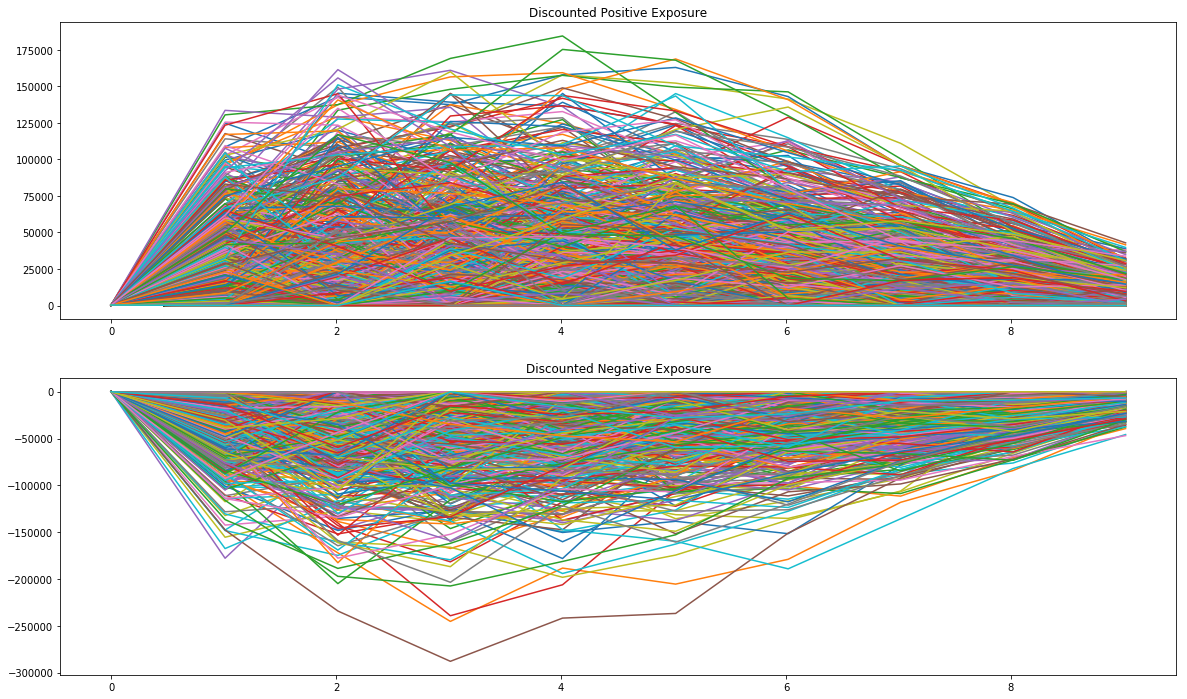

In [36]:
print("CVA: %0.2f" % CVA)
figure, axis = plt.subplots(2, 1, figsize=(20, 12))
axis[0].plot(time_grid, positive_exposure_disc.T)
axis[0].set_title("Discounted Positive Exposure")
axis[1].plot(time_grid,negative_exposure_disc.T)
axis[1].set_title("Discounted Negative Exposure")
plt.show()